In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/migration-nz/migration_nz.csv


In [2]:
# Installations
!pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 47.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=46cc0f9391087fde097c9ab53326f37c8a81c09e76f95b887fa89a4416682230
  Stored in directory: /root/.cache/pip/wheels/e9/43/d9/de0427ef97aeac94f853545b02a8c07661abe1f44b64a0266d
Successfully built pycountry


### Imports

In [3]:
### TENSORFLOW ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### OTHERS ###
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate as tbl
import geopandas as gp
import pycountry as pyc

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
# Data set
data = pd.read_csv("/kaggle/input/migration-nz/migration_nz.csv", header = 0)

# View
data.head(1)

,Measure,Country,Citizenship,Year,Value
0,Arrivals,Oceania,New Zealand Citizen,1979,11817.0


In [5]:
# Color palette
palette = sns.color_palette("viridis")

# Special palette for denoting loss values
loss_colors = sns.color_palette('flare')

# Data Exploration

Data set contents:
- 5 columns
- 86,526 records

In [6]:
# Size
print(f'There are {data.shape[0]} rows across {data.shape[1]} columns.')

There are 86526 rows across 5 columns.


In [7]:
# Checking dtype and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86526 entries, 0 to 86525
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Measure      86526 non-null  object 
 1   Country      86526 non-null  object 
 2   Citizenship  86526 non-null  object 
 3   Year         86526 non-null  int64  
 4   Value        86454 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.3+ MB


In [8]:
# For each object dtype, return the unique values
for cols in data.columns:
    if data[cols].dtype == 'object' or data[cols].dtype == 'int64':
        print(f'{cols}: {data[cols].nunique()}')

Measure: 3
Country: 253
Citizenship: 3
Year: 38


In [9]:
# Unique Values - Measure
print(f'Measure unique values:\n{data.Measure.value_counts()}')

Measure unique values:
Arrivals      28842
Departures    28842
Net           28842
Name: Measure, dtype: int64


In [10]:
# Unique Values - Year
print(f'Year unique values:\n{data.Year.value_counts()}')

Year unique values:
1979    2277
2007    2277
2000    2277
2001    2277
2002    2277
2003    2277
2004    2277
2005    2277
2006    2277
2008    2277
1980    2277
2009    2277
2010    2277
2011    2277
2012    2277
2013    2277
2014    2277
2016    2277
1999    2277
1998    2277
1997    2277
1996    2277
1981    2277
1982    2277
1983    2277
1984    2277
1985    2277
1986    2277
1987    2277
1988    2277
1989    2277
1990    2277
1991    2277
1994    2277
1992    2277
1993    2277
1995    2277
2015    2277
Name: Year, dtype: int64


In [11]:
# Unique Values - Country
print(f'Country unique values:\n{data.Country.value_counts()}')

Country unique values:
Oceania              342
US Virgin Islands    342
Puerto Rico          342
Paraguay             342
Suriname             342
                    ... 
Greece               342
Croatia              342
Hungary              342
Ireland              342
All countries        342
Name: Country, Length: 253, dtype: int64


In [12]:
# Summary of Value
data.Value.describe()

count     86454.000000
mean        254.669304
std        3123.604622
min      -42627.000000
25%           0.000000
50%           0.000000
75%           6.000000
max      127305.000000
Name: Value, dtype: float64

## Visualizations

Visualizations will be most effective when looking at the intersections of categorical variables. Example: Arrivals by year.

### Measure across Years
Within Measure, there are three categories:
- Arrivals, for individuals arriving to New Zealand.
- Departures, for individuals leaving New Zealand.
- Net, the difference between arrivals and departures.

There is an interesting question to ask about the Net migration per year in the timeframe of 1979 thru 2016.

In [13]:
# Years
years = [*data.Year.unique()]
years = sorted(years, reverse = False) # Do this step to ensure years are correctly sorted in ascending order

# Measures
measures = [*data.Measure.unique()]

In [14]:
# Function to calculate measure sum based on year
def measurePerYear(measure, year) -> int:
    """
        measure is "Arrivals", "Departures", or "Net"
        year in any int64 from 1979 thru 2016 that appears in years
        
    """
    # Return
    return int(data['Value'].loc[(data['Measure']==measure) & (data['Year']==year)].sum())

In [15]:
### Measures per year
# Lists
arrivals_per_year = []
departures_per_year = []
net_per_year = []

# Iterate to calculate
for y in years:
    arrivals_per_year.append(measurePerYear('Arrivals', y))
    departures_per_year.append(measurePerYear('Departures', y))
    net_per_year.append(measurePerYear('Net', y))

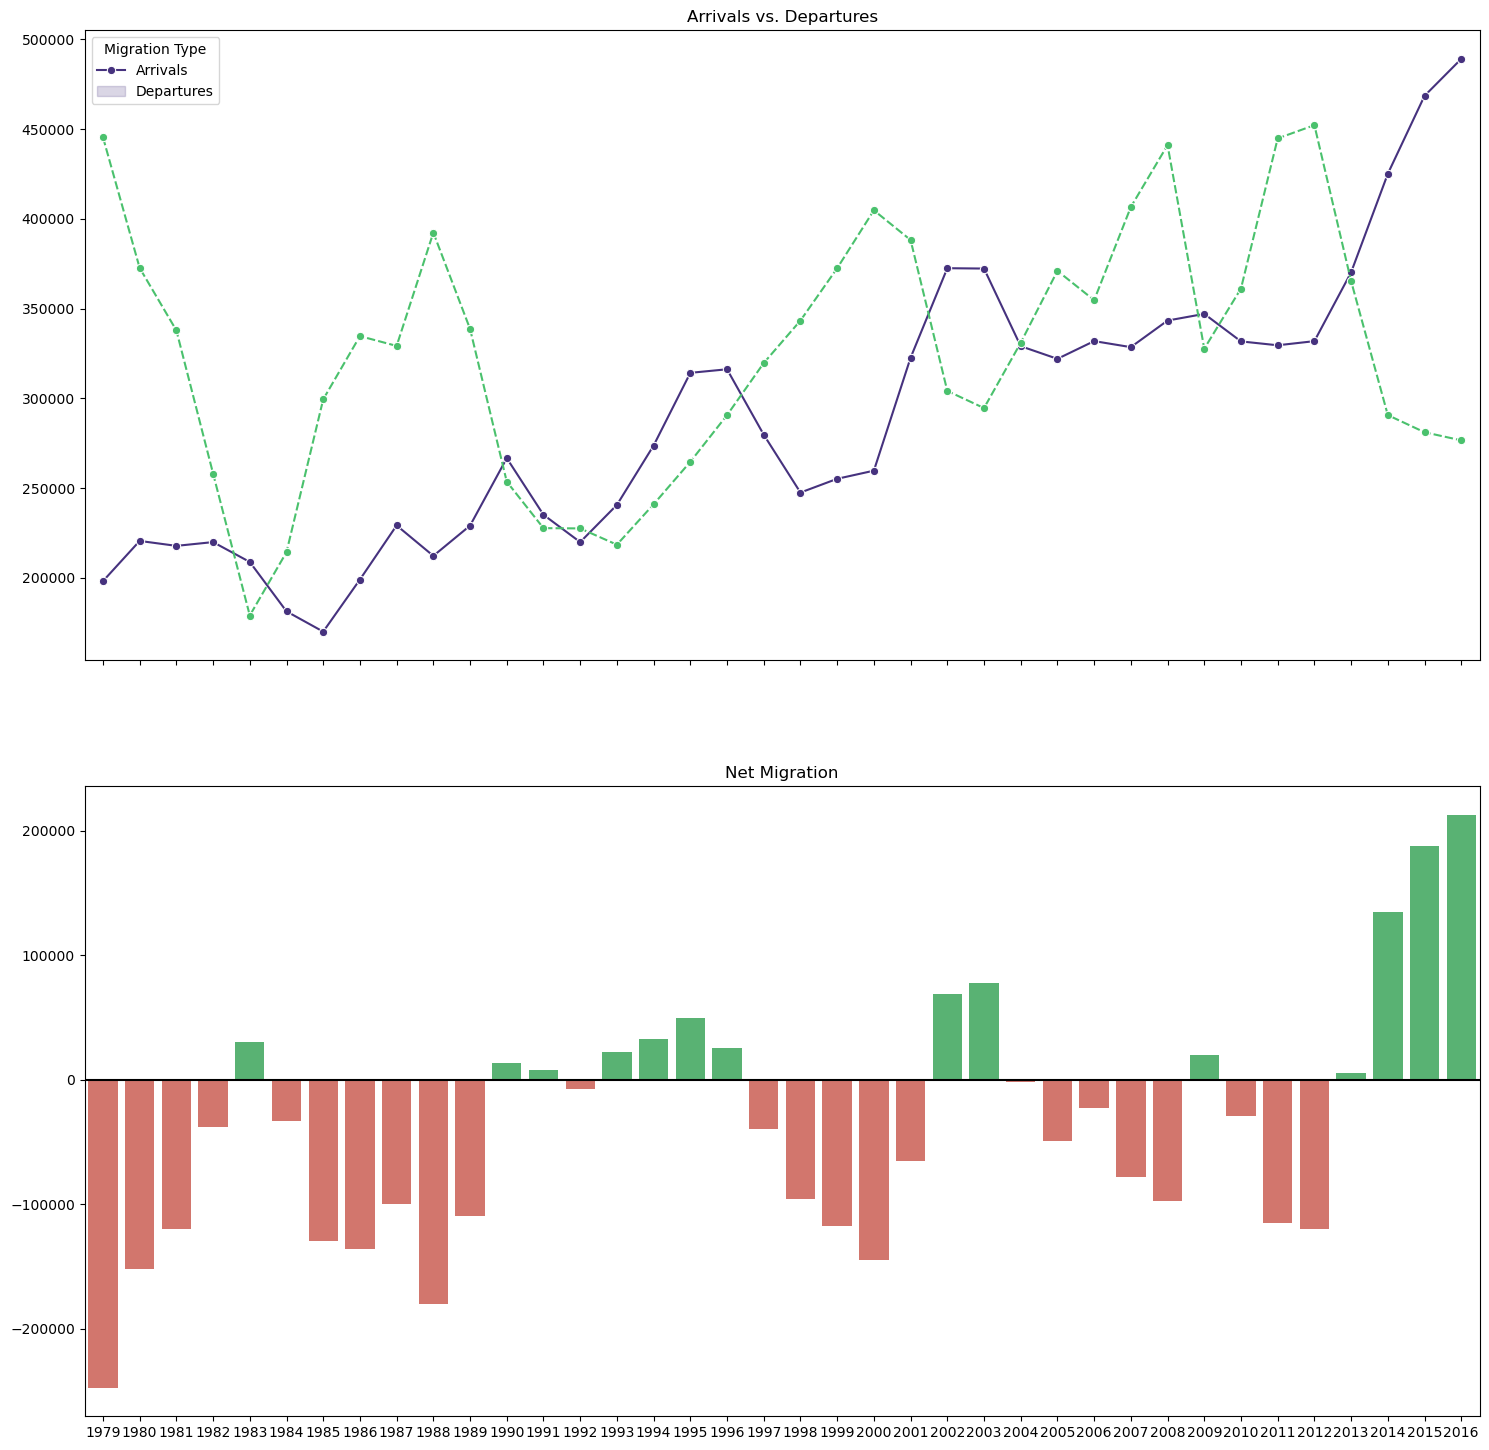

In [16]:
### Arrivals vs. Departures vs. Net
# Make subplots
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize = (18,18), sharex = True)

# Plots
sns.lineplot(data = [arrivals_per_year, departures_per_year],
             marker = "o",
             linestyle = 'dashed',
             palette = [palette[0], palette[4]],
             ax = ax0)
# Set the line chart title
ax0.set_title('Arrivals vs. Departures')
# Fix the legend
ax0.legend(title = "Migration Type", labels = ['Arrivals', 'Departures'])

# Centered barplot
sns.barplot(x=years, y=net_per_year, palette=[loss_colors[1] if y < 0 else palette[4] for y in net_per_year], ax=ax1)
# Center the axis
ax1.axhline(0, color = "black")
# Set the title for the barplot
ax1.set_title("Net Migration")

# View
fig.show()

In [17]:
### Create a table for plain language
# Compile necessary columsn into a dataframe
yearly_migration_summary = pd.DataFrame(list(zip(years, arrivals_per_year, departures_per_year, net_per_year)), columns = ["year", "arrivals_tot", "departures_tot", "net_tot"])

# Table
print(tbl.tabulate(yearly_migration_summary,
                    headers=["Years", "Total Arrivals", "Total Departures", "Total Net"],
                    tablefmt="prettytable"))

      Years    Total Arrivals    Total Departures    Total Net
--  -------  ----------------  ------------------  -----------
 0     1979            198066              445522      -247456
 1     1980            220485              372636      -152151
 2     1981            217738              337838      -120100
 3     1982            219837              258040       -38203
 4     1983            208758              178921        29837
 5     1984            181223              214240       -33017
 6     1985            169926              299412      -129486
 7     1986            198963              334655      -135692
 8     1987            229131              329183      -100052
 9     1988            212160              392351      -180191
10     1989            229013              338648      -109635
11     1990            266628              253520        13108
12     1991            235061              227605         7456
13     1992            219836              227461      

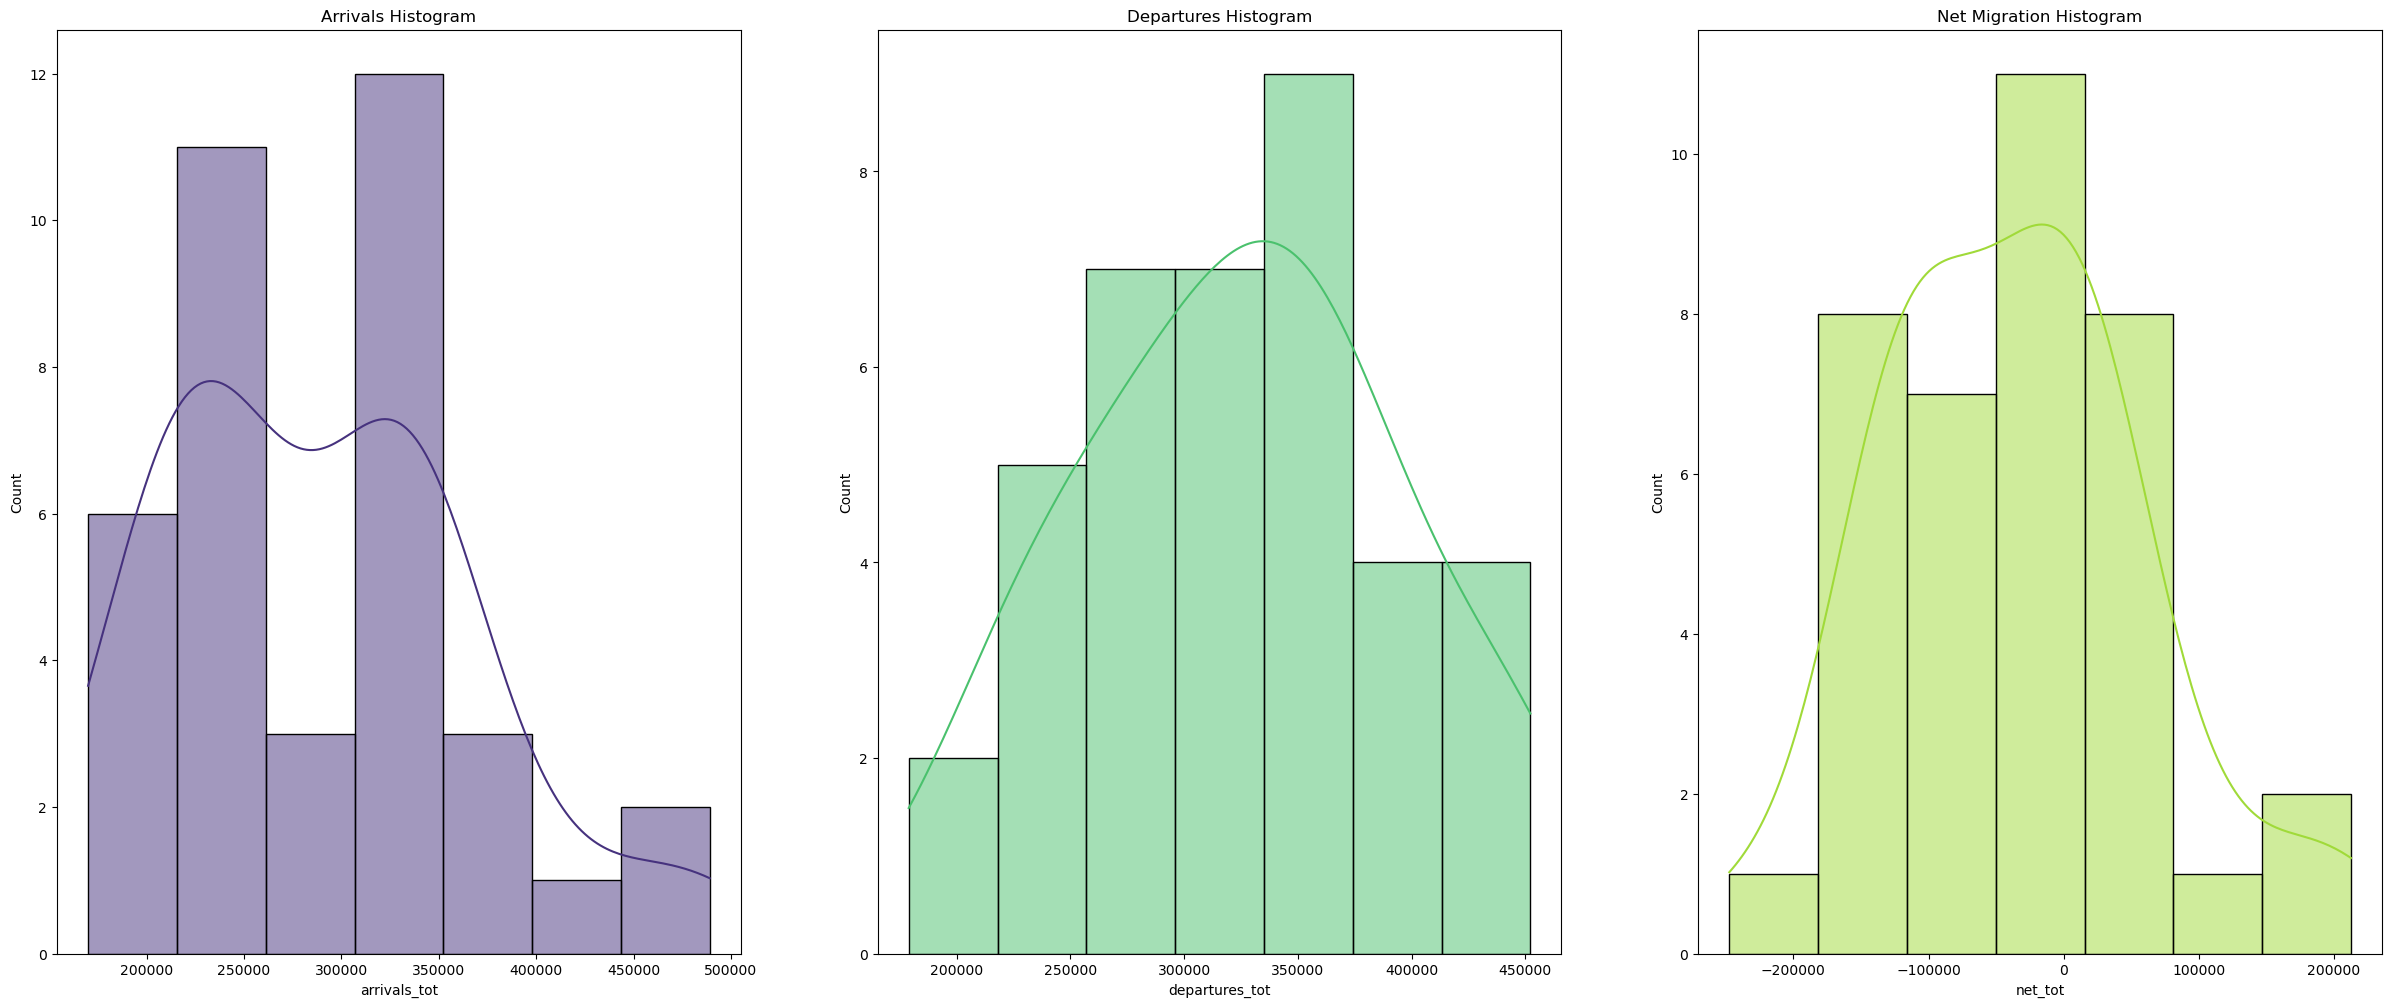

In [18]:
### Histograms of arrivals, departures, and net migration
# Make subplots
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize = (30,12))

# Arrivals
sns.histplot(data = yearly_migration_summary, x = 'arrivals_tot', kde = True, color = palette[0], ax = ax0)
ax0.set_title("Arrivals Histogram")

# Departures
sns.histplot(data = yearly_migration_summary, x = 'departures_tot', kde = True, color = palette[4], ax = ax1)
ax1.set_title("Departures Histogram")

# Net
sns.histplot(data = yearly_migration_summary, x = 'net_tot', kde = True, color = palette[5], ax = ax2)
ax2.set_title("Net Migration Histogram")

# View
fig.show()

Looking at the charts above, the Arrivals histogram shows some bi-modality. There may be world events at play during the timeframes where those spikes in arrivals occurred, such as economic distress or civil unrest, causing an influx of immigrants. On the other hand, departures from New Zealand seem to be near normally distributed. Net Migration, which is determined from Arrivals and Departures also seems somewhat normally distributed. However, because it is impacted by the two other distributions, any extreme occurrences (like bimodality), would influence the shape of the distribution.

### Countries
There are a lot of countries each year serving as the point of departure for migrants into New Zealand. To make the analysis easier, I will group those countries according to regions. Example:
- Paraguay in a category 'South America'
- Croatia, Hungary, Greece in a category 'Europe'

However, this part of the exploration will start with some overall calculations across 1979 thru 2016.

In [19]:
### Create the list of countries
countries = [*data.Country.unique()]

In [20]:
# Function to sum the amount of arrivals/departures from/to a particular country regardless of year
def countryMovementSum(measure, country) -> int:
    """
        measure is either "Arrivals" or "Departure."
        country is one of the str values from countries list.
        Will return an int64
        
    """
    return int(data['Value'].loc[(data['Measure']==measure) & (data['Country']==country)].sum())

In [21]:
# Calculate arrival and departure sums per country regardless of year
arrivals_per_country = []
departures_per_country = []

# Arrivals
for c in countries:
    arrivals_per_country.append(countryMovementSum("Arrivals", c))
    departures_per_country.append(countryMovementSum("Departures", c))
    
# Create a dataframe of just this information
country_movement_df = pd.DataFrame(list(zip(countries, arrivals_per_country, departures_per_country)), columns = ["countries", "arrivals_tot", "departures_tot"])
# Remove Not stated and All countries
clean_movement_df = country_movement_df[0:251]

In [22]:
### Arrivals world map
# STEP 1: Add relevant geopandas data into clean_movement_df
# Read in the world data
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres')) # Lowres earth file

# Head
world.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."


In the current data set, some of the existing country names are actually continent names, such as Oceania. That's fine, there will simply be repetition between the Country and Region column. In summary, the columns take from world and added to the clean_movement_df will be:
- continent
- geometry